# Machine learning approaches for crop yield prediction
Created by: Masoud Kheradmandi, masoud.kheradmandi@gmail.com 

## Summary: 
Target variable: Yield/Area

Prediction model: Linear regression, SVR, ANN

Insights into the data: Missing data, outlier, correlation, feature selection

final function as follows: **$\frac{Yield}{Area}=f(water,\text{ uv}, \text{ fertilizer_usage},\text{ pesticides},\text{  region dummies excluding regions 0 & 3},\text{ categories dummies excluding d}, \text{pesticides^2})$.**

The coefficient of linear model indicates which features have the the most effect on the output. For instance pesticides squared has the strongest effect and region 2 (a dummy variable) intercept has the weakest effect.

This work is organized as follows: First, the data is read and explored. Then the data cleansing is performed. Then different methods of modeling is explored and compared. Finally, concluding remarks and future works are presented.


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>


## Reading and exploring the data
At the beginning of the code, first all of the required packages are imported. Then the csv file is read in and explored.
### Importing packages 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import set_random_seed

Using TensorFlow backend.


### Reading the data


In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,id,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
0,169,5.615,65.281,3.230,0,7.977,8.969,0,"b,a,c"
1,476,7.044,73.319,9.081,0,23.009,7.197,0,"c,a,d"
2,152,5.607,60.038,2.864,2,23.019,7.424,0,"d,a"
3,293,9.346,64.719,2.797,2,28.066,1.256,0,d
4,10,7.969,NaN,5.407,1,29.140,0.274,0,"c,d"


### Creating dummy variables
The data has two features that require dummy variable definition:
- **region (6)**: there exist 7 possible regions therefor 6 dummy variables are defined.
- **categories (4)**: 4 dummy variables are defined to indicate if any of 4 possible pesticides are used.

In [3]:
#creating dummy variables
##For categories
d_a=np.zeros(len(df));d_b = np.zeros(len(df));d_c = np.zeros(len(df));d_d = np.zeros(len(df));
for i_r in range(len(df)):
    d_a[i_r]= 'a' in df.categories[i_r]
    d_b[i_r]= 'b' in df.categories[i_r]
    d_c[i_r]= 'c' in df.categories[i_r]
    d_d[i_r]= 'd' in df.categories[i_r]
    
df['dummy_a']=d_a;df['dummy_b']=d_b;df['dummy_c']=d_c;df['dummy_d']=d_d;
##Region
a1 = np.matrix(pd.get_dummies(df.region))
df['dummy_r0']=a1[:,0];df['dummy_r1']=a1[:,1];df['dummy_r2']=a1[:,2];df['dummy_r3']=a1[:,3];
df['dummy_r4']=a1[:,4];df['dummy_r5']=a1[:,5];df['dummy_r6']=a1[:,6];

### Target variable
The dependent variable is defined as follows:
    - Yield by hectare: total crop yield by farm per area of the farm in hectares
    
This variable is defined and added to the data frame.

In [4]:
df['yield_area']=df['yield']/df['area']

## Data cleaning
In this section, I perform outlier detection and dropping, also missing data handling. 
### Missing data
In two columns we have missing data. The missing data in uv and water were replaced with median in the previous section. Another alternative could have been dropping records with missing cells in practice we need to perform both and compare.

**Remark**:There are missing data in the water column(number of missing cells: 42~4.2%) and uv features(number of missing cells: 51~5.1%), together these rows make about 9 percent of the data, in order to be able to use these records they are replaced with median value instead of discarding them.

In [5]:
cdf = df
cdf.water = pd.DataFrame(cdf.water).replace(np.nan, pd.DataFrame.median(cdf.water))#Replacing NaN with median
cdf.uv = pd.DataFrame(cdf.uv).replace(np.nan, pd.DataFrame.median(cdf.uv))#Replacing NaN with median

### Outliers 
There is an obvious outlier in the water features. In order to drop the records with outliers, I used zscore in stats of scipy package. In order to do that, I first drop non numeric column.

In [6]:
cdf.drop(['yield','area','id','categories','region'], axis=1, inplace=True)
cdf = cdf[(np.abs(stats.zscore(df)) < 5).all(axis=1)].reset_index(drop=True)

**Remark**: There was an outlier in the water column which was removed. In the next section, the data are plotted.

### Data visualization
For Visualizing pairplot of data are plotted. The target variable is selected as yield per area. The new variable is calculated and added to data frame. Also the yield, area and id columns are dropped.


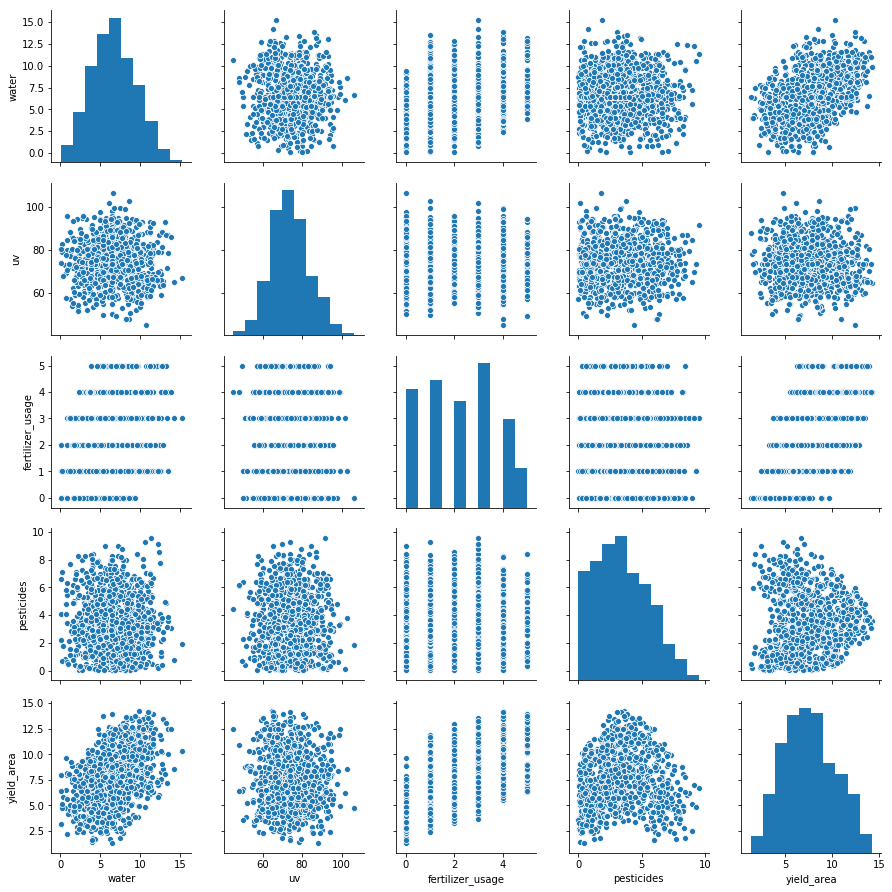

In [7]:
sns.pairplot(cdf,vars=['water','uv','fertilizer_usage','pesticides','yield_area'])
plt.show()

#### Remarks
-  The features are:
     1. water: There water had an outlier that is removed. The average amount of water received by hectare (is used in the original form, Had an outlier at id 586 or row 38)
     1. uv: The average amount of light received by hectare (is used in the original form). It seems like their is no correlation between uv an yield.
     1. fertilizer_usage: The level of fertilization (is used in the original form we assume that these levels are multiply of a constant value)
     1. pesticides: The amount of pesticides used per hectare (is used in the original form)
     1. region: region code (6 dummy variables (7 regions exist) are defined to represent each region)
     1. categories: comma-separated list of pesticides used
-  The dependent variable is defined as follows:
    - Yield by hectare: total crop yield divided area of the farm in hectares
    
#### Correlation between feature and target variables:
- Based on the figure the possible relationships between each feature and output are as follows: 
     1. water: linear
     1. uv: no visible correlation
     1. fertilizer_usage: linear
     1. pesticides: square
     1. region: considered as dummy variables
     1. categories: considered as dummy variables
- The model would have the following form:
    - $\frac{Yield}{Area}=f(water, uv, fertilizer\_usage, pesticides, region, categories)$

## Data driven modeling
In this section, final independent ($x_{final}$) and dependent ($y_{final}$) variables are created. Then, these input and output are utilized for data driven modeling with different regression methods, then results are discussed and compared.

In [8]:
#Creating dependent and independent variables matrices
x_final = np.zeros((len(cdf),14),dtype=np.float);
for i_x in range(np.shape(cdf)[1]-2):
    x_final[:,i_x] = pd.to_numeric(cdf[list(cdf)[i_x]])
y_final = np.zeros((len(cdf)));
y_final = pd.to_numeric(cdf['yield_area'])

### Normalizing data
Since almost all of the supervised learning techniques perform faster and more robust with normalized data, all of the variables are scaled between 0 and 1 by dividing them to their maximum values (all of the variables are positive).

In [9]:
#Normalizing data by dividing to maximum value of each column
max_x = np.max(x_final,axis=0)
for i_x in range(len(x_final[1])):
    x_final[:,i_x]= x_final[:,i_x]/max_x[i_x]    
max_y = np.max(y_final)
y_final = y_final/max_y
x_train, x_test, y_train, y_test= train_test_split(x_final, y_final, test_size=0.3, random_state=4,shuffle=True)

### Cross validation with K-fold
For better training and assessment of modeling performance, cross-validation is utilized. Here K-Fold method is used. 

In [10]:
#Modeling
seed = 40
np.random.seed(seed)
set_random_seed(seed)
kf = KFold(n_splits=4, shuffle=True, random_state=seed)

### Linear regression
Ordinary least square is utilized in this section. For model evaluation mean square error and r-squared are used.

In [11]:
rgr = LinearRegression()
scores_lr = cross_val_score(rgr, x_final, y_final, cv=kf,scoring='neg_mean_squared_error')
print("MSE with all of the original data: %0.4f (+/- %0.4f)" % (-scores_lr.mean(), scores_lr.std() * 2))
scores_lr = cross_val_score(rgr, x_final, y_final, cv=kf,scoring='r2')
print("R^2 of the model: %0.4f (+/- %0.4f)" % (scores_lr.mean(), scores_lr.std() * 2))

MSE with all of the original data: 0.0109 (+/- 0.0017)
R^2 of the model: 0.7020 (+/- 0.0618)


The r-squared being 0.7 means the linear relationship is not valid. In the next section first, the uv term is replaced with categories squared. For final case all original data with categories squared is used for input.

In [12]:
#Case 2 all clumns of cdf except yield_area, uv & dummy_r6 plus square(cdf['pesticides'])
x_final = np.zeros((len(cdf),14),dtype=np.float);
for i_x in range(np.shape(cdf)[1]-2):
    x_final[:,i_x] = pd.to_numeric(cdf[list(cdf)[i_x]])
x_final[:,1] = np.square(cdf['pesticides'])
#Normalizing data by dividing to maximum value of each column
max_x = np.max(x_final,axis=0)
for i_x in range(len(x_final[1])):
    x_final[:,i_x]= x_final[:,i_x]/max_x[i_x]
#Modeling
x_train, x_test, y_train, y_test= train_test_split(x_final, y_final, test_size=0.3, random_state=4,shuffle=True)
rgr = LinearRegression()
scores_lr = cross_val_score(rgr, x_final, y_final, cv=kf,scoring='neg_mean_squared_error')
print("MSE with square(pesticides) replacing uv: %0.4f (+/- %0.4f)" % (-scores_lr.mean(), scores_lr.std() * 2))
scores_lr = cross_val_score(rgr, x_final, y_final, cv=kf,scoring='r2')
print("R^2 of the model: %0.4f (+/- %0.4f)" % (scores_lr.mean(), scores_lr.std() * 2))

MSE with square(pesticides) replacing uv: 0.0055 (+/- 0.0007)
R^2 of the model: 0.8510 (+/- 0.0291)


As we can see, MSE is reduced and r-squared is increased. Then adding categories squared was a good idea.

In [13]:
#Case 3 all clumns of cdf except yield_area & dummy_r6 plus square(cdf['pesticides'])
x_final = np.zeros((len(cdf),15),dtype=np.float);
for i_x in range(np.shape(cdf)[1]-2):
    x_final[:,i_x] = pd.to_numeric(cdf[list(cdf)[i_x]])
x_final[:,14] = np.square(cdf['pesticides'])
#Normalizing data by dividing to maximum value of each column
max_x = np.max(x_final,axis=0)
for i_x in range(len(x_final[1])):
    x_final[:,i_x]= x_final[:,i_x]/max_x[i_x]
#Modeling
x_train, x_test, y_train, y_test= train_test_split(x_final, y_final, test_size=0.3, random_state=4,shuffle=True)
rgr = LinearRegression()
scores_lr = cross_val_score(rgr, x_final, y_final, cv=kf,scoring='neg_mean_squared_error')
print("MSE with square(pesticides) including uv: %0.4f (+/- %0.4f)" % (-scores_lr.mean(), scores_lr.std() * 2))
scores_lr = cross_val_score(rgr, x_final, y_final, cv=kf,scoring='r2')
print("R^2 of the model: %0.4f (+/- %0.4f)" % (scores_lr.mean(), scores_lr.std() * 2))

MSE with square(pesticides) including uv: 0.0053 (+/- 0.0007)
R^2 of the model: 0.8543 (+/- 0.0267)


These results indicate that with considering uv results are slightly better, then we will consider the final function as follows:
$\frac{Yield}{Area}=f(water, uv, fertilizer\_usage, pesticides, region dummies, categories dummies,pesticides^2)$.

The function has 15 inputs and one output.

**Remark-1**: The Stats Models package provides similar results with more statistical parameters such as confidence interval. But, here for simplicity sklearn was utilized.

**Remark-2**: The feature selection could be utilized for other features with the same method.

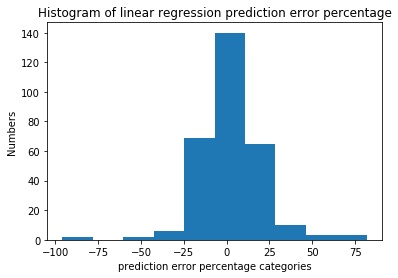

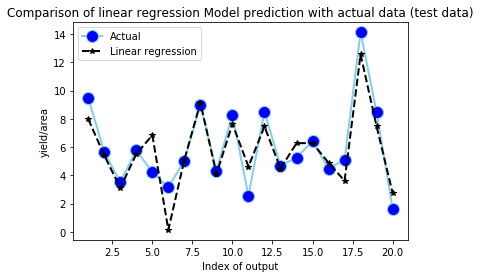

In [14]:
rgr.fit(x_train, y_train)
y_pred_lr=rgr.predict(x_test)
error_lr = (y_pred_lr-y_test)/y_test*100
plt.hist(error_lr)
plt.title('Histogram of linear regression prediction error percentage')
plt.xlabel('prediction error percentage categories')
plt.ylabel('Numbers')
plt.show()
plt.figure()
plt.plot( range(1,21),y_test[:20]*max_y, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2, label="Actual")
plt.plot( range(1,21),y_pred_lr[:20]*max_y, marker='*', color='black', linewidth=2, linestyle='dashed', label="Linear regression")
plt.legend()
plt.title('Comparison of linear regression Model prediction with actual data (test data)')
plt.xlabel('Index of output')
plt.ylabel('yield/area')
plt.show()

### Future selection
An important issue of any data driven modeling is feature selection to avoid adding unnecessary complexity to the model. In this section, I implement two methods, manual method and feature ranking with recursive feature elimination.
#### Manual method
In order to select futures, the linear regression will be utilized. The pair plots indicated that all of the features are correlated with target variable except uv. Also from pesticides behavior it seems that output has a nonlinear relation with it. So, square of pesticides can be another feature.

#### Feature ranking with recursive feature elimination
The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. To this end RFCV function from sklearn package with linear regression is used.

The rank of the feautures are:  [1 1 1 1 2 1 1 4 1 1 1 1 1 3 1]
MSE of final linear regression: 0.0053 (+/- 0.0007)


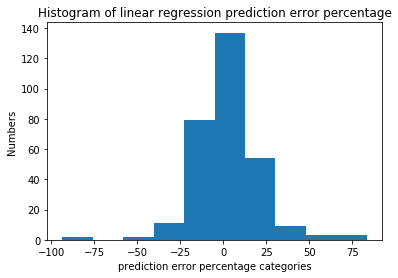

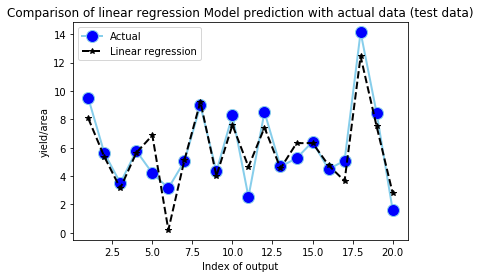

In [15]:
rgr_rfecv = RFECV(rgr, cv=kf, verbose=0)
rgr_rfecv.fit(x_final,y_final)
rnk = rgr_rfecv.ranking_
print('The rank of the feautures are: ',rnk)
idx_IN_columns = [i for i in range(np.shape(rnk)[0]) if rnk[i]==1]
x_final = x_final[:,idx_IN_columns]
x_train = x_train[:,idx_IN_columns]
x_test = x_test[:,idx_IN_columns]
scores_lr = cross_val_score(rgr, x_final, y_final, cv=kf,scoring='neg_mean_squared_error')
print("MSE of final linear regression: %0.4f (+/- %0.4f)" % (-scores_lr.mean(), scores_lr.std() * 2))
rgr.fit(x_train, y_train)
y_pred_lr=rgr.predict(x_test)
error_lr = (y_pred_lr-y_test)/y_test*100
plt.hist(error_lr)
plt.title('Histogram of linear regression prediction error percentage')
plt.xlabel('prediction error percentage categories')
plt.ylabel('Numbers')
plt.show()
plt.figure()
plt.plot( range(1,21),y_test[:20]*max_y, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2, label="Actual")
plt.plot( range(1,21),y_pred_lr[:20]*max_y, marker='*', color='black', linewidth=2, linestyle='dashed', label="Linear regression")
plt.legend()
plt.title('Comparison of linear regression Model prediction with actual data (test data)')
plt.xlabel('Index of output')
plt.ylabel('yield/area')
plt.show()

These results indicate that the dummy variables of region 0, region 3 and pesticide d can be dropped. Then we will consider the final function as follows:
**$\frac{Yield}{Area}=f(water,\text{ uv}, \text{ fertilizer_usage},\text{ pesticides},\text{  region dummies excluding regions 0 & 3},\text{ categories dummies excluding d}, \text{pesticides^2})$.**

Therefore from now on we will consider these variables.

In [16]:
print(rgr.coef_)

[ 0.24746141 -0.12433904  0.37976702  1.19437187 -0.02500834 -0.015423
  0.20115856  0.20744106  0.20075705  0.19413343  0.20619407 -1.39462483]


### Support Vector Machine - Regression (SVR)
In this section SVR model is identified using the final variables. A few kernel types can be used in the algorithm. I will implement three, ‘linear’, ‘poly’, ‘rbf’.

In [17]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.01)
svr_lin = SVR(gamma='auto',kernel='linear', C=1e3)
svr_poly = SVR(gamma='auto',kernel='poly', C=1e3, degree=2)

scores_rbf = cross_val_score(svr_rbf, x_final, y_final, cv=kf,scoring='neg_mean_squared_error')
print("MSE of svr_rbf: %0.4f (+/- %0.4f)" % (-scores_rbf.mean(), scores_rbf.std() * 2))

scores_lin = cross_val_score(svr_lin, x_final, y_final, cv=kf,scoring='neg_mean_squared_error')
print("MSE of svr_lin: %0.4f (+/- %0.4f)" % (-scores_lin.mean(), scores_lin.std() * 2))

scores_poly = cross_val_score(svr_poly, x_final, y_final, cv=kf,scoring='neg_mean_squared_error')
print("MSE of svr_poly: %0.4f (+/- %0.4f)" % (-scores_poly.mean(), scores_poly.std() * 2))

MSE of svr_rbf: 0.0046 (+/- 0.0003)
MSE of svr_lin: 0.0054 (+/- 0.0007)
MSE of svr_poly: 0.0050 (+/- 0.0006)


results indicate that SVR with radial basis function kernel has the best results, the least MSE and the most robust method (minimum std). Therefore we will choose SVR with rbf kernel from this group as the representative.

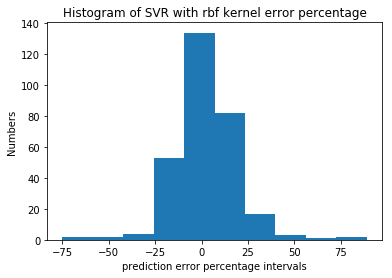

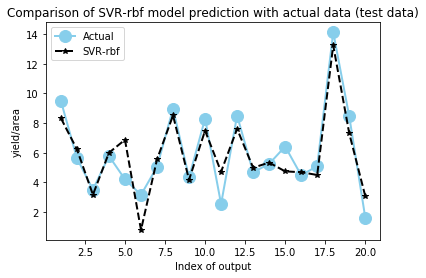

In [18]:
svr_rbf.fit(x_train, y_train)
y_pred_svr_rbf=svr_rbf.predict(x_test)
error_svr_rbf = (y_pred_svr_rbf-y_test)/y_test*100
plt.hist(error_svr_rbf)
plt.title('Histogram of SVR with rbf kernel error percentage')
plt.xlabel('prediction error percentage intervals')
plt.ylabel('Numbers')
plt.show()
plt.figure()
plt.plot( range(1,21),y_test[:20]*max_y, marker='o', markerfacecolor='skyblue', markersize=12, color='skyblue', linewidth=2, label="Actual")
plt.plot( range(1,21),y_pred_svr_rbf[:20]*max_y, marker='*', color='black', linewidth=2, linestyle='dashed', label="SVR-rbf")
plt.legend()
plt.title('Comparison of SVR-rbf model prediction with actual data (test data)')
plt.xlabel('Index of output')
plt.ylabel('yield/area')
plt.show()

### Neural Network
In this section an ANN is trained to model the system. The networks has three middle hidden layers with 20 neurons. The transfer functions are selected as sigmoid and keras package is utilized for this section.

In [ ]:
# define the model
n_x = np.shape(x_final)[1]
def bld_model():
	# create model
    model = Sequential()
    model.add(Dense(20, input_dim=12, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=1000, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5")
nn_mdl = KerasRegressor(build_fn=bld_model, epochs=100, verbose=0)
scores_nn = cross_val_score(nn_mdl, x_final, y_final, cv=kf,fit_params={'callbacks': [monitor, checkpointer]})
print("MSE of ANN: %0.4f (+/- %0.4f)" % (-scores_nn.mean(), scores_nn.std() * 2))

MSE of ANN: 0.0045 (+/- 0.0007)


In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=12, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train,y_train,callbacks=[monitor,checkpointer],verbose=0,epochs=100)

y_pred_nn = model.predict(x_test)[:,0]
error_nn = (y_pred_nn-y_test)/y_test*100
plt.hist(error_nn)
plt.title('Histogram of ANN prediction error percentage')
plt.xlabel('prediction error percentage intervals')
plt.ylabel('Numbers')
plt.show()
plt.figure()
plt.plot( range(1,21),y_test[:20]*max_y, marker='o', markerfacecolor='skyblue', markersize=12, color='skyblue', linewidth=2, label="Actual")
plt.plot( range(1,21),y_pred_nn[:20]*max_y, marker='*', color='black', linewidth=2, linestyle='dashed', label="ANN")
plt.legend()
plt.title('Comparison of ANN model prediction with actual data (test data)')
plt.xlabel('Index of output')
plt.ylabel('yield/area')
plt.show()

## Comparison of models
In this section, the results of best model of each section are compared. As we can see in the table below ANN has the best prediction and SVR_rbf is the most robust method. 

Other methods such as random forest or gradient boosting can be utilized for modeling.

In [ ]:
d = {'Method': ['Linear Regression', 'SCR_rbf','ANN'], 'MSE': [-scores_lr.mean(),-scores_rbf.mean(),-scores_nn.mean()], 'standard deviation': [scores_lr.std(),scores_rbf.std(),scores_nn.std()]}
df3 = pd.DataFrame(data=d)
df3.head()

In [ ]:
y_lr,binEdges_lr=np.histogram(error_lr)
bincenters_lr = 0.5*(binEdges_lr[1:]+binEdges_lr[:-1])
plt.plot(bincenters_lr,y_lr,'-', label="LR")

y_svr_rbf,binEdges_svr_rbf=np.histogram(error_svr_rbf)
bincenters_svr_rbf = 0.5*(binEdges_svr_rbf[1:]+binEdges_svr_rbf[:-1])
plt.plot(bincenters_svr_rbf,y_svr_rbf,'r-', label="SVR-RBF")

y_nn,binEdges_nn=np.histogram(error_nn)
bincenters_nn = 0.5*(binEdges_nn[1:]+binEdges_nn[:-1])
plt.plot(bincenters_nn,y_nn,'g-', label="ANN")
plt.title('Histogram of of ML models prediction error percentage (test data)')
plt.xlabel('Prediction error percentage')
plt.ylabel('Number')
plt.legend()
plt.xlim(-80,80)
plt.show()

## Conclusion
In this work, different methods of machine learning were utilized to model yield of a farm based on features such as water, pesticides and etc. In this work few methods were implemented and compared. The models are sorted from simplest to most complicated and all of them were trained well. The coefficient of linear model indicates which features have the the most effect on the output. For instance pesticides squared has the strongest effect and region 2 (a dummy variable) intercept has the weakest effect.

## Future work
IN this section two possible future works are presented. Based on any of the models the company can create a decision support system to maximize it's profit, means by finding the cheapest improvement (lowest cost) on the system which results in maximum income.

### Profit optimization 
The identified models can be utilize to maximize the profit of the costumer with the following formula:
$$\max_{u} c_{Y}^TY-c_{I}^Tu\\\text{s.t.}\\ \qquad \qquad ML model\\  \qquad \qquad constraints$$.

Where $c_{Y}$ and $c_{I}$ are the vectors of yields and features costs which build the objective function and represent profit of the system. It is possible that the features and yields cost vary for different farms. $Y$ and $u$ denote target and independent variables. Also, any kind of constraints such as input bounds can be included in the formula.
### Supply-chain management
Based on the model the supply chain problem can be solved, means find the best feature values that meets the company's demand and also has the most profit.
$$\min_{u} c_{I}^Tu\\\text{s.t.}\\ \qquad \qquad ML model\\   \qquad \qquad  Y=demands\\  \qquad \qquad constraints$$.